# ***رَصْد | Rasd***
# ***AI-Based System for Car Accident Detection and Analysis***

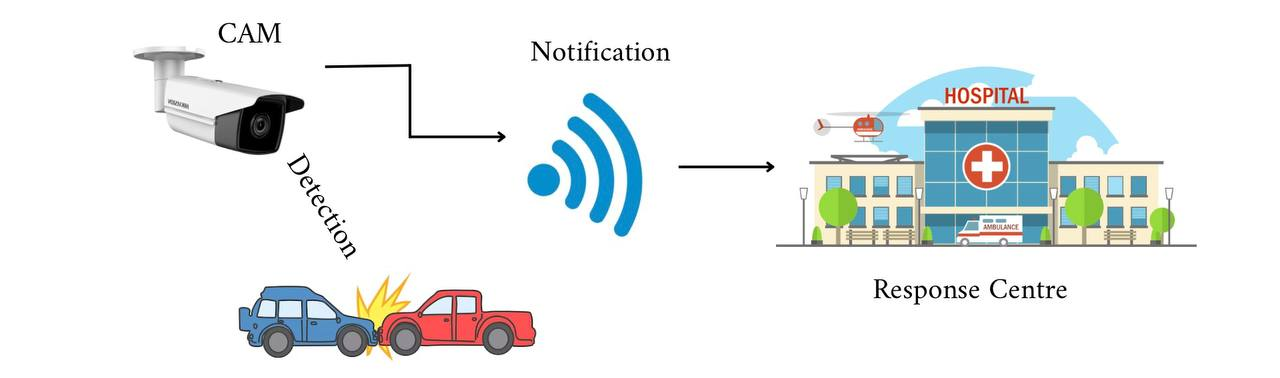

*Car accidents pose a serious global challenge, often leading to severe consequences due to delays in emergency response. Traditional accident detection methods rely on manual reporting, which can be slow and inaccurate, negatively impacting response speed and the ability of emergency teams to intervene promptly.*

**What is “Rasd”?**

*“Rasd” is an AI-powered system designed to detect accidents in real-time through live video analysis. The system leverages deep learning techniques to identify collisions, assess their severity, and send instant alerts to emergency services, enabling a faster response and minimizing damage.*

**Why do we need “Rasd” ?**
    
    

1.   Traditional methods depend on human intervention, leading to delays in notifying the relevant authorities.
2.   Accidents may be reported inaccurately or late, increasing the severity of the situation.

1.  Slow response times can worsen injuries and increase fatalities due to delayed medical assistance.






**How does “Rasd” work?**



1.  Analyzing live video feeds from surveillance cameras.
2.  Utilizing AI to detect accidents and classify their severity.

1.  Sending instant alerts to emergency teams as soon as an accident is detected.
2.  Processing data to extract insights that improve road safety.





**Project Goals:**


*   Accelerate emergency response by enabling instant accident reporting.
*   Reduce injuries and fatalities caused by delayed interventions.


*  Enhance road safety using advanced AI-driven solutions.
*   Analyze traffic accident data to improve future transportation policies.





# ***Import Libraries***

In [ ]:
!pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import os
import cv2
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
import random
import shutil
import albumentations as A
from google.colab import drive
drive.mount('/content/drive')
import plotly.express as px
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import multiprocessing
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["savefig.format"] = "png"
import sys

Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 41.0/235.7 GB disk)


# ***Importing Data and Preperation***

In [ ]:
dataset_path = "/content/drive/MyDrive/AccidentsDetectionData"
train_images_path = os.path.join(dataset_path, "train/images/")
valid_images_path = os.path.join(dataset_path, "valid/images/")
test_images_path = os.path.join(dataset_path, "test/images/")
train_labels_path = os.path.join(dataset_path, "train/labels/")
valid_labels_path = os.path.join(dataset_path, "valid/labels/")

In [ ]:
def process_file(img_name, images_path, labels_path):
    label_file = os.path.join(labels_path, img_name.rsplit('.', 1)[0] + '.txt')
    if os.path.exists(label_file):
        try:
            with open(label_file, "r") as f:
                line = f.readline().strip()
                if not line:
                    return None, None
                return (img_name, None) if line.split()[0] == "0" else (None, img_name)
        except:
            return None, None
    return None, None

def load_accident_data(images_path, labels_path):
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]

    with multiprocessing.Pool() as pool:
        results = pool.starmap(process_file, [(img, images_path, labels_path) for img in image_files])

    if not results:
        return [], []

    minor_accidents = [img for img, _ in results if img]
    severe_accidents = [img for _, img in results if img]

    print(f"Minor accidents count: {len(minor_accidents)}")
    print(f"Severe accidents count: {len(severe_accidents)}")

    return minor_accidents, severe_accidents

In [ ]:
minor_accidents, severe_accidents = load_accident_data(train_images_path, train_labels_path)

# ***Data Visualization (EDA)***

In [ ]:
label_counts = {
    "Minor Accident": len(minor_accidents),
    "Severe Accident": len(severe_accidents)
}

df = pd.DataFrame({
    "Accident Type": list(label_counts.keys()),
    "Count": list(label_counts.values())
})

df["Percentage"] = (df["Count"] / df["Count"].sum() * 100).round(2)

fig = px.bar(
    df,
    x="Count",
    y="Accident Type",
    orientation="h",
    text=df["Percentage"].astype(str) + "%",
    title=f"📊 Accident Type Distribution (Total: {df['Count'].sum()})",
    color="Accident Type",
    color_discrete_map={"Minor Accident": "#7886C7", "Severe Accident": "#A9B5DF"},
    template="plotly_dark"
)

fig.update_traces(textposition="outside")
fig.show()

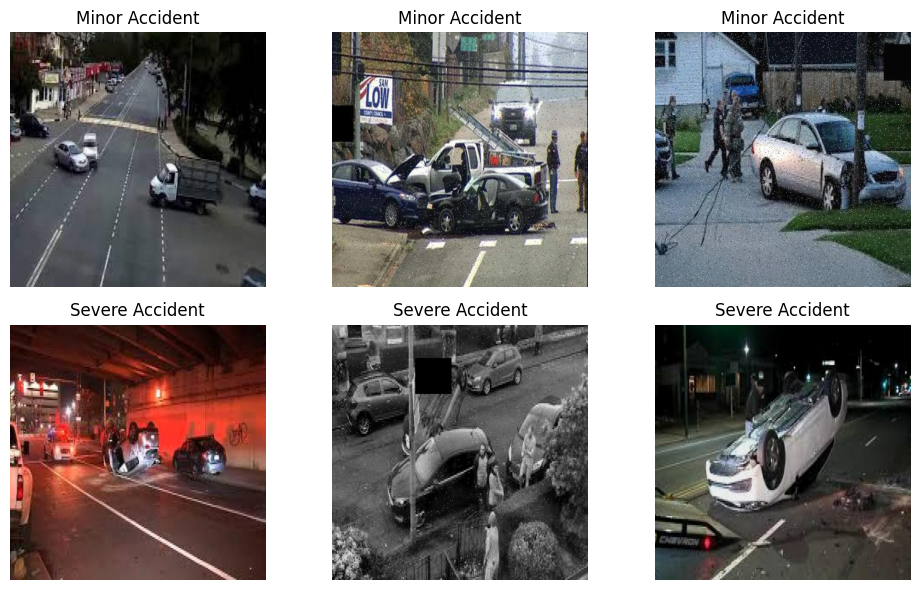

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

minor_samples = random.sample(minor_accidents, 3)
severe_samples = random.sample(severe_accidents, 3)

for i, img_name in enumerate(minor_samples):
    img_path = os.path.join(train_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Minor Accident")
    axes[0, i].axis("off")

for i, img_name in enumerate(severe_samples):
    img_path = os.path.join(train_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Severe Accident")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

# ***YOLO Architecture***

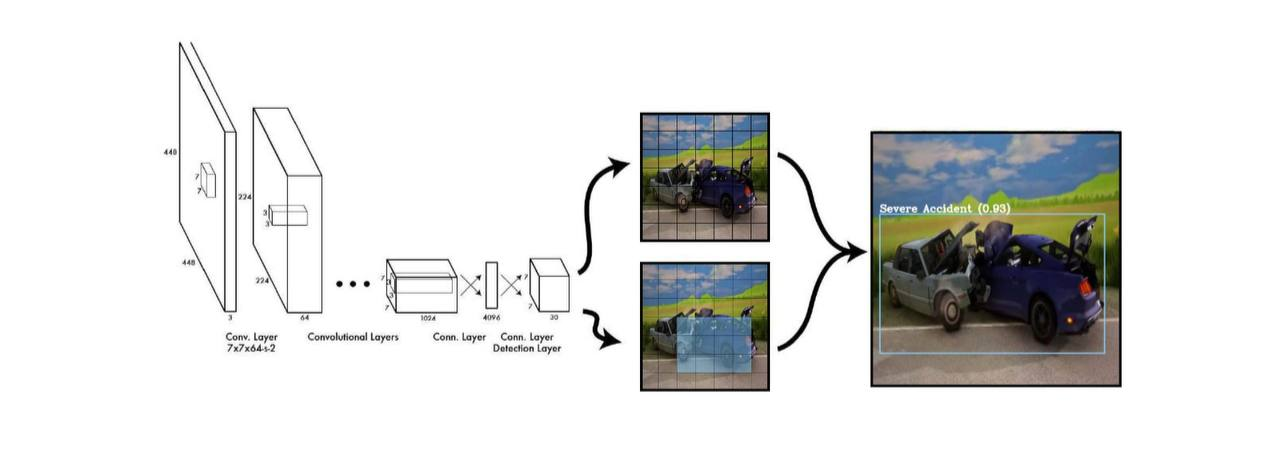

# ***Train Model***

In [ ]:
model = YOLO("yolov8x.pt")
model.train(
    data="/content/drive/MyDrive/AccidentsDetectionData/data.yaml",
    epochs=50,
    batch=32,
    imgsz=640,
    conf=0.4,
    iou=0.6,
    device="cuda",
    augment=True,
    mosaic=True,
    mixup=True,
)

100%|██████████| 131M/131M [00:00<00:00, 283MB/s]


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/AccidentsDetectionData/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.4, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.9MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AccidentsDetectionData/train/labels.cache... 14318 images, 1600 backgrounds, 0 corrupt: 100%|██████████| 15659/15659 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/AccidentsDetectionData/valid/labels.cache... 1004 images, 26 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        23G      1.269      1.884      1.664         35        640: 100%|██████████| 490/490 [06:57<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]

                   all       1004       1003      0.863      0.714      0.821      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      22.7G      1.102      1.314      1.513         42        640: 100%|██████████| 490/490 [03:22<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1004       1003      0.847      0.707      0.817      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50        23G      1.195      1.469      1.584         41        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1004       1003      0.561       0.58        0.6       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      22.9G      1.297      1.647      1.679         44        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1004       1003       0.74      0.659      0.756      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      22.9G      1.204      1.491       1.61         40        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all       1004       1003      0.822      0.675      0.784      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      22.9G      1.119      1.348      1.541         44        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1004       1003      0.828      0.717      0.821      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50        23G      1.056      1.239      1.495         45        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]

                   all       1004       1003      0.838      0.731      0.834      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      22.9G      1.008      1.167      1.456         34        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1004       1003      0.846      0.736       0.83      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50        23G     0.9567      1.097      1.416         37        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1004       1003      0.895      0.708      0.834      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50        23G     0.9312      1.058        1.4         31        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1004       1003      0.854      0.762      0.852      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50        23G     0.8942      1.011      1.371         35        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1004       1003      0.856      0.765      0.856       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      22.9G     0.8716     0.9759      1.345         34        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1004       1003      0.866      0.777      0.864      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50        23G     0.8475     0.9387      1.327         24        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.897      0.759      0.864      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50        23G     0.8206      0.906      1.312         43        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.884       0.75      0.847      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50        23G     0.8035     0.8837      1.298         29        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1004       1003      0.938      0.749      0.866      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      22.9G     0.7894     0.8624      1.281         33        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.922      0.762      0.873      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      22.9G     0.7688     0.8402      1.273         41        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.898      0.794      0.877      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      22.9G      0.741     0.8097      1.254         39        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003       0.92      0.757      0.868      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      22.9G     0.7307     0.7923      1.243         36        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1004       1003      0.901      0.746      0.859      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50        23G     0.7134     0.7695       1.23         36        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1004       1003      0.918      0.766      0.876      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50        23G     0.6991     0.7589      1.224         41        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1004       1003      0.922      0.786      0.885      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      22.9G     0.6855     0.7399       1.21         34        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]

                   all       1004       1003      0.909      0.757      0.873      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      22.9G     0.6795     0.7288      1.204         45        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1004       1003      0.872      0.793      0.874       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      22.9G     0.6662     0.7153      1.189         37        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

                   all       1004       1003      0.898      0.782      0.876      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      22.9G     0.6517     0.7052       1.19         40        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1004       1003      0.937      0.777      0.883      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      22.9G     0.6339      0.681      1.173         44        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1004       1003      0.908      0.783      0.878      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      22.9G       0.63     0.6734      1.169         42        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1004       1003      0.928      0.765      0.879      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      22.9G     0.6194     0.6704      1.161         32        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.909      0.772      0.876      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        23G     0.6043     0.6481      1.142         39        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1004       1003      0.933      0.767      0.871      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      22.9G     0.5983     0.6383      1.141         45        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1004       1003      0.883      0.799      0.877      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      22.9G     0.5873     0.6322      1.137         42        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]

                   all       1004       1003      0.904      0.784      0.878       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      22.9G     0.5783     0.6182      1.128         38        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1004       1003      0.931      0.776      0.872       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50        23G     0.5673     0.6058      1.124         46        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all       1004       1003      0.891      0.786      0.869      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      22.9G     0.5586     0.6002      1.114         29        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]

                   all       1004       1003      0.902      0.776      0.874      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      22.9G     0.5528     0.5943       1.11         39        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all       1004       1003      0.939      0.763      0.876      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50        23G     0.5395     0.5859      1.101         39        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]

                   all       1004       1003      0.924      0.782      0.879       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50        23G     0.5306     0.5677      1.096         39        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]

                   all       1004       1003      0.895      0.802      0.884      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50        23G     0.5246      0.571      1.089         33        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all       1004       1003      0.957      0.735       0.87      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50        23G     0.5121     0.5566      1.085         45        640: 100%|██████████| 490/490 [03:17<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1004       1003      0.892      0.784      0.874      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      22.9G     0.5079     0.5484       1.08         39        640: 100%|██████████| 490/490 [03:18<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.935       0.75      0.871      0.832


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      22.9G     0.3005     0.3547     0.9094         12        640: 100%|██████████| 490/490 [03:15<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all       1004       1003      0.931      0.755      0.863      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      22.9G     0.2824     0.3359     0.8931          8        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all       1004       1003      0.931       0.76      0.868      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      22.9G     0.2682     0.3265     0.8843          9        640: 100%|██████████| 490/490 [03:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]

                   all       1004       1003      0.955      0.752      0.869       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      22.9G     0.2499      0.316     0.8747          9        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all       1004       1003      0.944      0.763      0.873      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50        23G     0.2362     0.3088     0.8709          9        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]

                   all       1004       1003       0.96      0.745      0.865      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      22.9G     0.2239     0.2995     0.8657          9        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all       1004       1003      0.941      0.752      0.865      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      22.9G     0.2123     0.2915     0.8581          8        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]

                   all       1004       1003      0.938      0.752      0.864      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      22.9G      0.202     0.2873     0.8523         10        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.58it/s]

                   all       1004       1003      0.944       0.74      0.861      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      22.9G     0.1906     0.2778     0.8468         10        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1004       1003       0.94      0.748      0.863      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      22.9G     0.1821     0.2703     0.8408         13        640: 100%|██████████| 490/490 [03:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]

                   all       1004       1003      0.946      0.749      0.864      0.839



50 epochs completed in 2.918 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


                   all       1004       1003      0.929      0.775      0.874      0.847
        Minor Accident        349        351      0.939      0.698      0.837      0.824
       Severe Accident        634        652      0.919      0.853      0.911       0.87
Speed: 0.1ms preprocess, 8.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bd94c8965d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
model = YOLO("/content/drive/MyDrive/yolo11x_training_backup/detect/train/weights/best.pt")
model.train(resume=True)

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/yolo11x_training_backup/detect/train/weights/best.pt, data=/content/drive/MyDrive/AccidentsDetectionData/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=/content/drive/MyDrive/yolo11x_training_backup/detect/train/weights/best.pt, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=

100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]


TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 8.02MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AccidentsDetectionData/train/labels.cache... 14318 images, 1600 backgrounds, 0 corrupt: 100%|██████████| 15659/15659 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/AccidentsDetectionData/valid/labels.cache... 1004 images, 26 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Resuming training /content/drive/MyDrive/yolo11x_training_backup/detect/train/weights/best.pt from epoch 76 to 100 total epochs
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      15.6G      0.364     0.4093      0.978         20        640: 100%|██████████| 979/979 [10:38<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]

                   all       1004       1003      0.959      0.762      0.895      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      15.3G     0.3672      0.417     0.9746         23        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.55it/s]

                   all       1004       1003      0.958      0.761      0.895      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      15.3G     0.3589      0.409     0.9713         22        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]

                   all       1004       1003      0.957       0.76      0.894      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      15.1G     0.3523     0.4053     0.9629         27        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       1003      0.954      0.763      0.895      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      15.3G     0.3446     0.4003     0.9596         12        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]

                   all       1004       1003      0.947      0.768      0.896      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      15.3G     0.3425     0.3933     0.9582         22        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       1003      0.944      0.764      0.896      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      15.3G      0.337     0.3852     0.9538         16        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.43it/s]

                   all       1004       1003      0.941      0.766      0.896      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      15.1G      0.329     0.3835     0.9516         24        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.50it/s]

                   all       1004       1003      0.937      0.773      0.897      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      15.3G     0.3241     0.3757     0.9469         18        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1004       1003      0.938       0.77      0.896      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      15.3G     0.3228     0.3751      0.948         17        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]

                   all       1004       1003      0.935      0.775      0.895      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      15.3G     0.3165     0.3724     0.9445         14        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.46it/s]

                   all       1004       1003      0.933      0.774      0.895      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      15.1G     0.3115     0.3676     0.9383         17        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       1003      0.932      0.774      0.895      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      15.3G     0.3102     0.3676     0.9389         15        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.41it/s]

                   all       1004       1003      0.941      0.771      0.894      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      15.3G     0.2993     0.3537     0.9354         20        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       1003      0.944      0.771      0.895      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      15.3G     0.2957     0.3536     0.9367         21        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       1003      0.943      0.771      0.895      0.823


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      15.1G     0.2344     0.3003     0.8669         12        640: 100%|██████████| 979/979 [04:01<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       1003      0.944       0.77      0.895      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      15.3G     0.2248     0.2962     0.8609          7        640: 100%|██████████| 979/979 [04:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.42it/s]

                   all       1004       1003      0.944      0.769      0.895      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      15.3G      0.218     0.2873     0.8548         11        640: 100%|██████████| 979/979 [04:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]

                   all       1004       1003      0.933      0.775      0.895      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      15.3G     0.2155     0.2872     0.8542         11        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.38it/s]

                   all       1004       1003      0.938      0.775      0.894      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      15.1G     0.2083     0.2823      0.851         10        640: 100%|██████████| 979/979 [04:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       1003      0.943      0.773      0.894      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      15.3G        inf     0.2779     0.8515          9        640: 100%|██████████| 979/979 [04:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.47it/s]

                   all       1004       1003      0.955      0.766      0.894      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      15.3G     0.1985     0.2764     0.8428         10        640: 100%|██████████| 979/979 [04:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.44it/s]

                   all       1004       1003      0.957      0.766      0.893      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      15.3G     0.1943      0.272     0.8437          9        640: 100%|██████████| 979/979 [04:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.48it/s]

                   all       1004       1003      0.964      0.766      0.894      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      15.1G      0.192     0.2689     0.8437         10        640: 100%|██████████| 979/979 [04:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.53it/s]

                   all       1004       1003      0.963      0.766      0.893      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      15.3G     0.1863     0.2663     0.8425         10        640: 100%|██████████| 979/979 [04:01<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]

                   all       1004       1003       0.96      0.766      0.893      0.825



25 epochs completed in 1.849 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 114.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 114.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 190 layers, 56,829,334 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.05it/s]


                   all       1004       1003      0.937      0.774      0.897      0.825
        Minor Accident        349        351      0.928        0.7      0.834      0.764
       Severe Accident        634        652      0.945      0.848       0.96      0.887
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dfed7b17350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
model = YOLO('yolov12l.pt')

model.train(data='/content/drive/MyDrive/AccidentsDetectionData/data.yaml',
            epochs=100,
            imgsz=640,
            batch=32,
            augment=True)

New https://pypi.org/project/ultralytics/8.3.80 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov12l.pt, data=/content/drive/MyDrive/AccidentsDetectionData/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=

100%|██████████| 5.34M/5.34M [00:00<00:00, 141MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/AccidentsDetectionData/train/labels.cache... 14318 images, 1600 backgrounds, 0 corrupt: 100%|██████████| 15659/15659 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/content/yolov12/yolov12/ultralytics/data/augment.py:1853: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/drive/MyDrive/AccidentsDetectionData/valid/labels.cache... 1004 images, 26 backgrounds, 0 corrupt: 100%|██████████| 1004/1004 [00:00<?, ?it/s]


Plotting labels to /content/yolov12/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0005), 211 bias(decay=0.0)
TensorBoard: WARNING ⚠️ TensorBoard graph visualization failure Tracing failed sanity checks!
ERROR: Graphs differed across invocations!
	Graph diff:
		  graph(%self.1 : __torch__.ultralytics.nn.tasks.DetectionModel,
		        %x.1 : Tensor):
		    %model : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="model"](%self.1)
		    %_21 : __torch__.ultralytics.nn.modules.head.Detect = prim::GetAttr[name="21"](%model)
		    %model.43 : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="model"](%self.1)
		    %_20 : __torch__.ultralytics.nn.modules.block.C3k2 = prim::GetAttr[name="20"](%model.43)
		    %model.41

      1/100      24.4G      1.002      1.599      1.468         16        640: 100%|██████████| 490/490 [03:29<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]

                   all       1004       1003       0.74      0.779      0.781       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      24.1G      1.077      1.235      1.491         15        640: 100%|██████████| 490/490 [03:20<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all       1004       1003      0.701      0.594      0.672      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      24.2G      1.228       1.48      1.595         20        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]

                   all       1004       1003      0.454      0.258      0.282      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      24.2G      1.311      1.631      1.672         18        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.56it/s]

                   all       1004       1003      0.613      0.602      0.617      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      24.2G      1.183        1.4      1.569         20        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1004       1003       0.68      0.677      0.711      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      24.2G       1.08      1.223      1.483         22        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all       1004       1003      0.745      0.745      0.798      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      24.2G      1.005      1.103      1.431         18        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all       1004       1003      0.799      0.727      0.814      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      24.2G     0.9686      1.035      1.398         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

                   all       1004       1003      0.851       0.73      0.846      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      24.2G     0.9166     0.9642      1.364         18        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1004       1003      0.782      0.826      0.858      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      24.2G     0.8846     0.9325      1.336         19        640: 100%|██████████| 490/490 [03:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.833      0.774      0.849      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      24.2G     0.8573     0.8775      1.324         20        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.788      0.797      0.849      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      24.2G     0.8183     0.8337       1.29         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.852      0.788       0.86      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      24.2G     0.7949     0.7978      1.276         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1004       1003      0.866      0.823      0.878      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      24.2G     0.7703     0.7708      1.259         22        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1004       1003      0.819      0.809      0.868       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      24.2G     0.7492      0.744      1.244         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all       1004       1003      0.871      0.833      0.901      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      24.2G     0.7374     0.7349      1.235         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]

                   all       1004       1003      0.872      0.797      0.858      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      24.2G     0.7136      0.715      1.219         15        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.841      0.849      0.882      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      24.2G     0.6953     0.6913      1.204         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.886      0.792      0.872       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      24.2G     0.6807     0.6727      1.192         16        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.843      0.821      0.879       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      24.2G     0.6776      0.664      1.187         26        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.886      0.822       0.89      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      24.2G     0.6578     0.6475      1.172         14        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.887      0.816      0.869      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      24.2G     0.6445     0.6436      1.156         26        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.899      0.793      0.884      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      24.2G     0.6305     0.6256      1.155         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.894       0.79       0.89      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      24.2G      0.622     0.6127      1.143         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1004       1003      0.893      0.811      0.883      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      24.2G      0.605     0.6005       1.13         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.919      0.792      0.891      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      24.2G     0.5978     0.5896      1.132         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.889      0.815      0.879      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      24.2G     0.5844     0.5778      1.118         22        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003       0.92      0.808      0.894      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      24.2G     0.5815     0.5747      1.115         15        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.913      0.817      0.898      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      24.2G     0.5765     0.5712      1.116         17        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1004       1003      0.876      0.817      0.897      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      24.2G     0.5552     0.5459        1.1         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.905      0.823      0.892      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      24.2G     0.5484     0.5426      1.088         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.918      0.799      0.893      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      24.2G     0.5416     0.5387      1.085         29        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.906      0.805      0.891      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      24.2G     0.5378     0.5414      1.084         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.912      0.797      0.895      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      24.2G      0.525      0.517      1.078         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.917      0.784      0.897      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      24.2G      0.519     0.5236       1.07         20        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1004       1003      0.902      0.814      0.885      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      24.2G     0.5124     0.5202      1.067         23        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.903      0.799      0.891      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      24.2G     0.5051     0.5072      1.055         14        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.941      0.799      0.901      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      24.2G     0.5001      0.504      1.053         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all       1004       1003      0.934      0.788      0.894      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      24.2G     0.4892     0.4903      1.047         14        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.924      0.783      0.892      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      24.2G     0.4795     0.4881      1.045         24        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.891      0.815      0.895      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      24.2G     0.4854     0.4875      1.046         23        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1004       1003      0.925      0.806      0.897      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      24.2G     0.4737     0.4806      1.038         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.938      0.791        0.9       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      24.2G     0.4676     0.4783      1.039         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1004       1003      0.943      0.807      0.896      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      24.2G     0.4619     0.4762      1.039         17        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.67it/s]

                   all       1004       1003      0.921      0.808      0.891       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      24.2G     0.4544     0.4728       1.03         17        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all       1004       1003      0.945      0.791      0.887      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      24.2G     0.4512      0.456      1.025         27        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.926      0.774      0.876      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      24.2G     0.4403     0.4533      1.017         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all       1004       1003      0.931      0.775      0.874      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      24.2G      0.434     0.4517      1.015         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all       1004       1003      0.943      0.766      0.873      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      24.2G     0.4319     0.4492      1.015         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.928      0.783      0.877      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      24.2G     0.4246      0.443      1.011         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all       1004       1003      0.937      0.775      0.879      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      24.2G     0.4199     0.4381      1.003         17        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.952      0.772      0.879      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      24.2G     0.4165     0.4343      1.002         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.945      0.783      0.878      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      24.2G     0.4142     0.4346     0.9999         22        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.67it/s]

                   all       1004       1003      0.951      0.776      0.879      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      24.2G      0.409     0.4333          1         15        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.924      0.789      0.885      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      24.2G     0.4027     0.4281     0.9941         17        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.935      0.785      0.884      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      24.2G     0.3927     0.4163     0.9891         14        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all       1004       1003      0.936      0.786      0.882      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      24.2G      0.397     0.4207     0.9869         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all       1004       1003      0.937      0.787      0.878      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      24.2G     0.3839     0.4121     0.9753         20        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.932       0.79      0.877      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      24.2G     0.3799     0.4093     0.9789         14        640: 100%|██████████| 490/490 [03:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.937      0.785      0.879      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      24.2G     0.3811     0.4073     0.9739         25        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003       0.95      0.787      0.882      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      24.2G     0.3788     0.4037      0.975         20        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.948      0.783      0.879      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      24.2G     0.3722     0.3983     0.9707         18        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.945      0.781      0.881      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      24.2G     0.3678     0.3972     0.9684         15        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1004       1003       0.94      0.783      0.881       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      24.2G     0.3664     0.3973      0.967         24        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]

                   all       1004       1003      0.942      0.779      0.883      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      24.2G     0.3605      0.391     0.9618         13        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.947      0.774      0.884       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      24.1G      0.353     0.3841     0.9542         19        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003       0.94      0.781      0.883      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      24.2G     0.3493      0.382     0.9582         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.944      0.778      0.882      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      24.2G      0.344     0.3791     0.9566         22        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]

                   all       1004       1003      0.945      0.775      0.882      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      24.2G     0.3418     0.3779      0.953         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all       1004       1003      0.941      0.774      0.882      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      24.2G     0.3352     0.3735     0.9473         18        640: 100%|██████████| 490/490 [03:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.941      0.771      0.882      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      24.2G     0.3327     0.3702     0.9496         15        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1004       1003      0.941      0.771      0.882      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      24.2G     0.3243     0.3673     0.9465         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.941      0.774      0.882      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      24.2G     0.3251     0.3603     0.9464         14        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.941      0.774      0.883      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      24.2G     0.3196     0.3609     0.9389         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1004       1003       0.94      0.772      0.883      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      24.1G     0.3162     0.3574     0.9404         15        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all       1004       1003      0.944      0.771      0.882      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      24.2G     0.3134     0.3527     0.9382         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1004       1003      0.945      0.771      0.884      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      24.2G     0.3112      0.356     0.9377         13        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all       1004       1003      0.943       0.77      0.884      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      24.2G     0.3074     0.3546     0.9325         16        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

                   all       1004       1003      0.943       0.77      0.883      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      24.2G     0.2997     0.3433     0.9297         17        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]

                   all       1004       1003      0.943      0.771      0.883      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      24.2G     0.2994     0.3443     0.9294         17        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.943       0.77      0.881      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      24.2G     0.2898     0.3363     0.9245         13        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.943       0.77      0.881      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      24.2G     0.2894     0.3405     0.9231         24        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003       0.94      0.771      0.881      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      24.2G     0.2846     0.3351     0.9244         28        640: 100%|██████████| 490/490 [03:14<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003       0.93      0.774      0.881      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      24.2G     0.2831     0.3297     0.9214         20        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.927      0.774      0.881      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      24.2G     0.2804     0.3298     0.9215         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1004       1003      0.926      0.774       0.88      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      24.2G     0.2773     0.3276     0.9187         19        640: 100%|██████████| 490/490 [03:14<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1004       1003      0.929      0.774      0.881      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      24.2G     0.2712     0.3237     0.9155         19        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.931      0.773       0.88      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      24.2G     0.2674     0.3231      0.913         18        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1004       1003      0.931      0.774       0.88      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      24.2G     0.2608     0.3122     0.9089         13        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]

                   all       1004       1003      0.931      0.774      0.881      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      24.2G     0.2605     0.3195       0.91         21        640: 100%|██████████| 490/490 [03:13<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003      0.934      0.773      0.881      0.818


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/content/yolov12/yolov12/ultralytics/data/augment.py:1853: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      24.1G        0.2     0.2692      0.841         10        640: 100%|██████████| 490/490 [03:15<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1004       1003      0.932      0.772      0.881      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      24.2G     0.1929     0.2647     0.8364         11        640: 100%|██████████| 490/490 [03:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.935      0.772       0.88      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      24.2G     0.1867     0.2616     0.8364         11        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

                   all       1004       1003      0.936      0.772      0.879      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      24.2G     0.1805     0.2577      0.832         10        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.62it/s]

                   all       1004       1003      0.937      0.772      0.879      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      24.2G     0.1758     0.2545     0.8259          8        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]

                   all       1004       1003      0.938      0.773      0.879       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      24.2G     0.1729     0.2513     0.8285         11        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.71it/s]

                   all       1004       1003      0.938       0.77      0.879       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      24.2G     0.1676     0.2454     0.8269          9        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.938      0.769       0.88       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      24.2G     0.1629     0.2445     0.8239         10        640: 100%|██████████| 490/490 [03:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]

                   all       1004       1003       0.94      0.769      0.879       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      24.2G     0.1589     0.2427     0.8258         10        640: 100%|██████████| 490/490 [03:13<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]

                   all       1004       1003      0.944      0.767      0.879      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      24.2G     0.1555     0.2369     0.8217          9        640: 100%|██████████| 490/490 [03:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.72it/s]

                   all       1004       1003      0.946      0.768      0.879      0.821



100 epochs completed in 5.600 hours.
Optimizer stripped from /content/yolov12/runs/detect/train/weights/last.pt, 53.5MB
Optimizer stripped from /content/yolov12/runs/detect/train/weights/best.pt, 53.5MB

Validating /content/yolov12/runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12l summary (fused): 626 layers, 26,340,614 parameters, 0 gradients, 88.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


                   all       1004       1003      0.944      0.788      0.889      0.821
        Minor Accident        349        351      0.957      0.732       0.83      0.768
       Severe Accident        634        652      0.931      0.844      0.949      0.875
Speed: 0.1ms preprocess, 6.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/yolov12/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2164a44510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# ***Evaluation***

In [ ]:
df_8 = pd.read_csv("/content/drive/MyDrive/Yolo_Models/Yolo_Runs/detect/train/results.csv")
df_11 = pd.read_csv("/content/drive/MyDrive/runs_yolo_11/detect/train/results.csv")
df_12 = pd.read_csv("/content/drive/MyDrive/YOLO12/runs_new/detect/train/results.csv")

required_columns = ["metrics/precision(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

def get_best_epoch(df, model_name):
    df = df.fillna(0)
    if all(col in df.columns for col in required_columns):
        best_epoch = df.loc[df["metrics/mAP50-95(B)"].idxmax()]
        return {
            "Model": model_name,
            "Precision": best_epoch["metrics/precision(B)"] * 100,
            "mAP@50": best_epoch["metrics/mAP50(B)"] * 100,
            "mAP@50-95": best_epoch["metrics/mAP50-95(B)"] * 100
        }
    else:
        print(f"Warning: Missing required columns in {model_name} dataset!")
        return {"Model": model_name, "Precision": 0, "mAP@50": 0, "mAP@50-95": 0}

yolo11_metrics = get_best_epoch(df_11, "YOLOv11")
yolo8_metrics = get_best_epoch(df_8, "YOLOv8")
yolo12_metrics = get_best_epoch(df_12, "YOLOv12")

df_comparison = pd.DataFrame([yolo11_metrics, yolo8_metrics, yolo12_metrics])
df_melted = df_comparison.melt(id_vars=["Model"], var_name="Metric", value_name="Value")

fig = px.bar(
    df_melted, x="Model", y="Value", color="Metric", barmode="group",
    title="YOLO Models Comparison Based on Best Epoch",
    labels={"Value": "Accuracy Score (%)"},
    color_discrete_sequence=["#7F60A6", "#A88DC8", "#C2A6DC"]
)

fig.update_traces(texttemplate='%{y:.2f}%', textposition='outside')
fig.update_layout(
    yaxis=dict(range=[0, 107]),
    plot_bgcolor="#222",
    paper_bgcolor="#222",
    font=dict(color="white")
)
fig.update_yaxes(showgrid=True, gridcolor="dimgray")
fig.show()

# ***Predection***

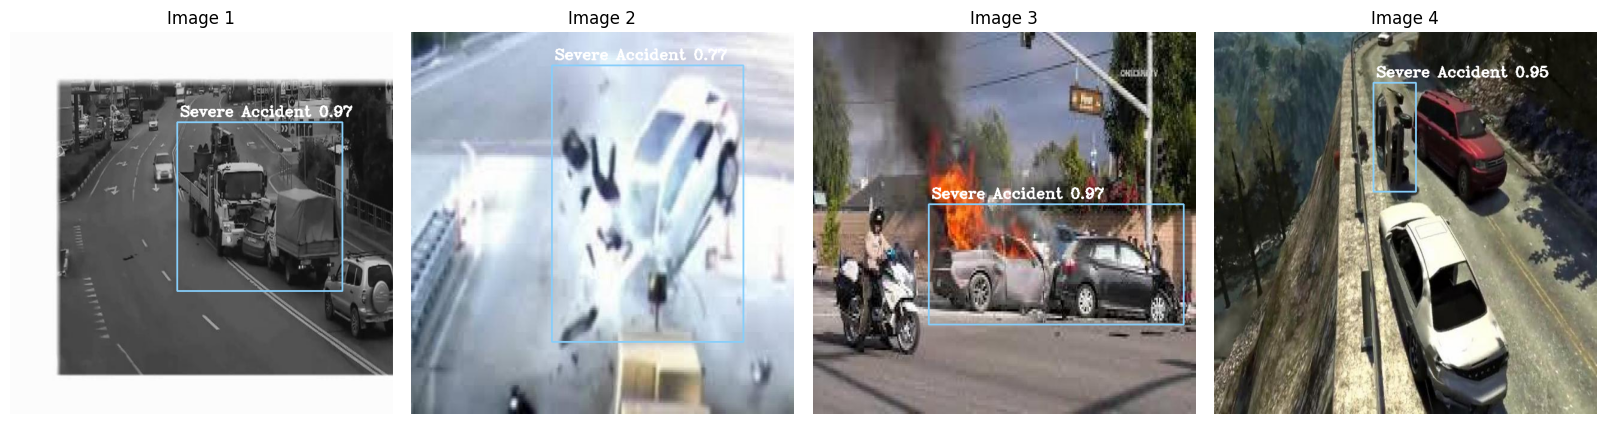

In [ ]:
model = YOLO("/content/drive/MyDrive/runs_yolo_11/detect/train/weights/best.pt")

image_folder = "/content/drive/MyDrive/AccidentsDetectionData/test/images"
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
random_images = random.sample(image_files, 4)

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

def draw_box_and_text(img, box, label, color):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    thickness = 2
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    cv2.putText(img, label, (x1 + 5, y1 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.8, (255, 255, 255), 2)

for i, img_name in enumerate(random_images):
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error loading image: {img_name}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
        results = model(img)

    ax = axes[i]

    for result in results:
        for box in result.boxes:
            conf = float(box.conf[0])
            class_name = result.names[int(box.cls[0])]
            label = f"{class_name} {conf:.2f}"
            color = (135, 206, 250) if class_name == "Severe Accident" else (169, 169, 169)
            draw_box_and_text(img_rgb, box, label, color)

    ax.imshow(img_rgb)
    ax.set_title(f"Image {i+1}")
    ax.axis("off")

plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()